Import all the packages we will use

In [13]:
# so editing bimpy source code will reload without restarting the Jupyter kernal
%load_ext autoreload
%autoreload 2

import math
import numpy as np

%matplotlib notebook
from matplotlib import pyplot as plt

import bimpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load a stack and all its analysis.

In [34]:
path = '/Users/cudmore/box/Sites/DeepVess/data/20200228/blur/20200228__0001_z.tif'
path = '/Users/cudmore/box/Sites/DeepVess/data/20200127/blur/20200127_gel_0011_z.tif'

stack = bimpy.bStack(path=path, loadImages=True)

# do this when I add new analysis to bImPy code
# I am re-analyzing here because I added 'tort' to analysis and is not in saved h5f file.
'''
stack.slabList._analyze()
stack.saveAnnotations() # save h5f file
'''

stack.slabList._printStats()

=== bVascularTracing.load() /Users/cudmore/box/Sites/DeepVess/data/20200127/blur/20200127_gel_0011_z.h5f
    loaded nodes: 232 edges: 604
20200127_gel_0011_z.tif slabs: 6751 nodes: 233 edges: 605


Analyze the diameter of each slab/point in the tracing.

This is slow (20-30 sec). I need to add this to main code so it is saved with other analysis.

There are a few parameters here that can be important for the analysis of each slab

- lineWidth: Width of line to extract intensity profile
- meadianFilter: Number of pixels in median filter applied to line profile
- radius: [CRITICAL] The radius of the line intensity profile. If too short, vessel will not be covered, if too long, line will collide with other vessels.


In [35]:
lp = bimpy.bLineProfile(stack)

#print('analyzing intensity of all slabs ... ...')
startTime = bimpy.util.bTimer()
nEdges = stack.slabList.numEdges()
meanDiamList = [] # mean diam per segment based on Vesselucida
meanDiamList2 = [] # my intensity calculation
lengthList = []
tortList = []
numAnalyzed = 0
for edgeIdx in range(nEdges):
    edgeDict = stack.slabList.getEdge(edgeIdx)

    thisDiamList = []

    for slabIdx in edgeDict['slabList']:
        lpDict = lp.getLine(slabIdx, radius=20) # default is radius=30

        if lpDict is not None:
            retDict = lp.getIntensity(lpDict, lineWidth=5, medianFilter=3)
            if retDict is not None:
                thisDiamList.append(retDict['diam']) # bImPy diameter
                numAnalyzed += 1
        else:
            pass

    if len(thisDiamList) > 0:
        thisDiamMean = np.nanmean(thisDiamList)
    else:
        thisDiamMean = np.nan
    meanDiamList2.append(thisDiamMean)
    meanDiamList.append(edgeDict['Diam']) # vessellucida
    lengthList.append(edgeDict['Len 3D'])
    tortList.append(edgeDict['Tort'])

print('   bImpy number of slabs analyzed:', numAnalyzed, startTime.elapsed())


   bImpy number of slabs analyzed: 5682  took 24.01 seconds


In [36]:
def getStat(aList):
    theMean = np.nanmean(aList)
    theSD = np.nanstd(aList)
    theN = np.count_nonzero(~np.isnan(aList))
    theSE = theSD / math.sqrt(theN)
    return theMean, theSD, theSE, theN

m,sd,se,n = getStat(meanDiamList2)
print('bImpy vessel diameter: mean', m, 'sd:', sd, 'se:', se, 'n:', n)
m,sd,se,n = getStat(meanDiamList)
print('Vesselucida vessel diameter: mean', m, 'sd:', sd, 'se:', se, 'n:', n)
m,sd,se,n = getStat(lengthList)
print('Vessel length: mean', m, 'sd:', sd, 'se:', se, 'n:', n)
m,sd,se,n = getStat(tortList)
print('Vessel Tortuosity: mean', m, 'sd:', sd, 'se:', se, 'n:', n)

# ask if the Vesselucida and bImpy vessel diameters are the same ...
from scipy import stats
clean1 = [x for x in meanDiamList2 if str(x) != 'nan']
clean2 = [x for x in meanDiamList if str(x) != 'nan']
t, p = stats.ttest_ind(clean1, clean2) # vessel diameter from Vesselucida vs bImPy
print('ttest t:', t, 'p:', p)


bImpy vessel diameter: mean 13.178517025081085 sd: 6.50783111363376 se: 0.2699903287729877 n: 581
Vesselucida vessel diameter: mean 11.187206611570247 sd: 5.582453410578418 se: 0.2269590055868888 n: 605
Vessel length: mean 70.60547107438016 sd: 65.59581691952675 se: 2.666849194030776 n: 605
Vessel Tortuosity: mean 1.2430088495575222 sd: 0.4093906219463442 se: 0.027232259089583224 n: 226
ttest t: 5.658362187792635 p: 1.91537592183741e-08


<IPython.core.display.Javascript object>


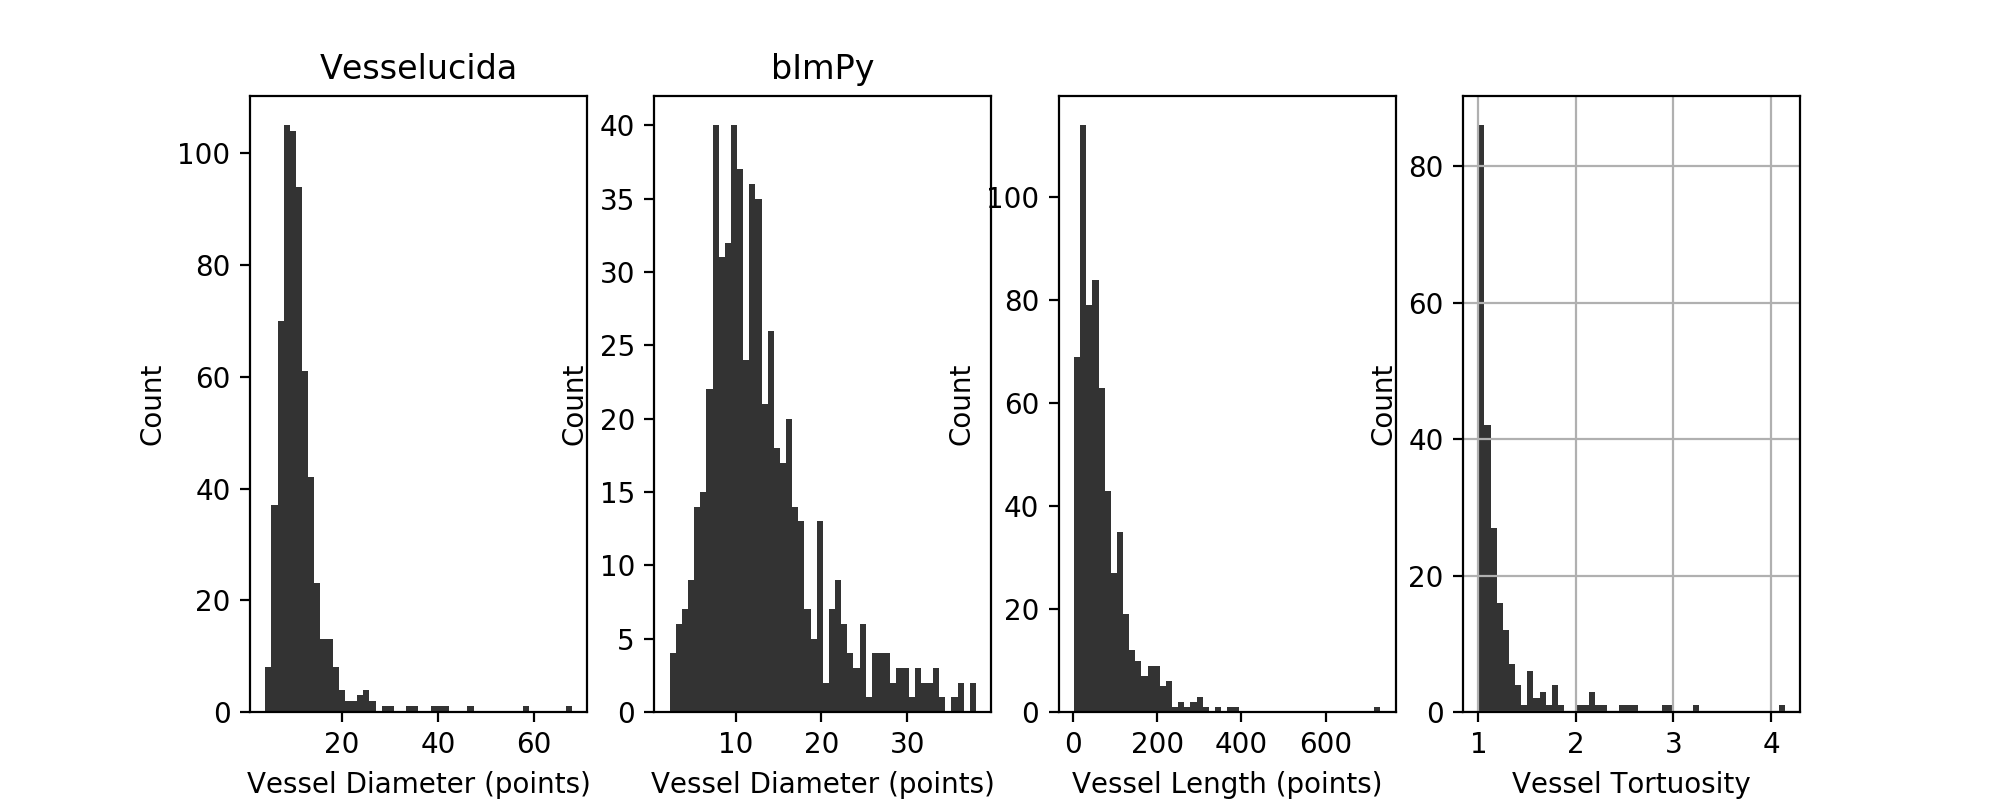

In [37]:
# plot the results

fig = plt.figure(figsize=(10,4))

alpha = 0.8 #0.75

ax = plt.subplot(141)
ax.set_title('Vesselucida')
n, bins, patches = plt.hist(meanDiamList, 50, density=False, facecolor='k', alpha=alpha)
plt.xlabel('Vessel Diameter (points)')
plt.ylabel('Count')

ax = plt.subplot(142)
ax.set_title('bImPy')
n, bins, patches = plt.hist(meanDiamList2, 50, density=False, facecolor='k', alpha=alpha)
plt.xlabel('Vessel Diameter (points)')
plt.ylabel('Count')

plt.subplot(143)
n, bins, patches = plt.hist(lengthList, 50, density=False, facecolor='k', alpha=alpha)
plt.xlabel('Vessel Length (points)')
plt.ylabel('Count')

plt.subplot(144)
n, bins, patches = plt.hist(tortList, 50, density=False, facecolor='k', alpha=alpha)
plt.xlabel('Vessel Tortuosity')
plt.ylabel('Count')

plt.grid(True)
plt.show()
